0. Set Up

In [1]:
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

fatal: destination path 'Demeter_metamorphosis' already exists and is not an empty directory.


Install packages

In [2]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=5b434dce7c66098ccbff03c5a42b1cd08643fee8af06b9c30f814d3d9aa0c1d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ww9c2uum/wheels/c7/71/aa/4dfac81c8e26328effd94ced03987bdc69e149508d2e247f6c
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

0.2 After jupyter restart, run:

In [1]:
# %matplotlib widget

import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



/content/Demeter_metamorphosis
['/content/Demeter_metamorphosis/', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython']


# 1. Code utile

In [2]:
import os
import nibabel as nib
import numpy as np
import torch

import demeter.utils.torchbox as tb
import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
## Faire Recalage Rigid + Meta
import demeter.metamorphosis as mt
import demeter.metamorphosis.rotate as mtrt
import demeter.utils.reproducing_kernels as rk
import matplotlib.pyplot as plt


def to_torch(img):
    return torch.from_numpy(img)[None, None]

def normalize(img):
    quant = np.quantile(img, 0.99)
    print(quant, img.max())
    img = np.clip(img, 0,quant)
    img /= img.max()
    return img

/usr/local/lib/python3.11/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


🔍 Vérification de l'environnement Matplotlib interactif...
❌ ipympl (nécessaire pour `%matplotlib widget`) n'est pas installé.
👉 Exécute : `pip install ipympl` dans une cellule ou un terminal.
saves_overview.csv


## Open images

In [3]:
# Open template
if "content" in cwd:
  template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
  ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
else:
  template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
  ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer/IXI002/mri/"

template_name = "mni_icbm152_t1_tal_nlin_asym_09c.nii"
template_mask_name = "mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"

template = nib.load(os.path.join(template_folder, template_name)).get_fdata()
template_mask = nib.load(os.path.join(template_folder, template_mask_name)).get_fdata()
template[template_mask == 0] = 0
# TODO : Open segs

print("template :",template.shape)

# Open ixi image

# ixi_list = os.listdir(ixi_folder)
ixi_image_name = "orig_nu.mgz"
ixi_segs_name = "aseg.auto_noCCseg.mgz"
ixi_mask_name = "mask.mgz"
ixi_img = nib.load(os.path.join(ixi_folder, ixi_image_name)).get_fdata()
ixi_segs = nib.load(os.path.join(ixi_folder, ixi_segs_name)).get_fdata()
ixi_mask = nib.load(os.path.join(ixi_folder, ixi_mask_name)).get_fdata()
ixi_img[ixi_mask == 0] = 0
# ixi_img= ixi_img[:, ::-1]
print("ixi_img :",ixi_img.shape)
print("ixi_segs :",ixi_segs.shape)
name = "IXI002_to_template"


# Normalise images to [0,1]
template = normalize(template)
ixi_img = normalize(ixi_img)

#  Resize ixi image
template = to_torch(template)
template = tb.resize_image(template, scale_factor= 1)
ixi_img = to_torch(ixi_img)
ixi_img = tb.resize_image(ixi_img, to_shape=template.shape[2:])

print(ixi_img.shape)

template : (193, 229, 193)
ixi_img : (192, 256, 256)
ixi_segs : (192, 256, 256)
89.21373212197796 97.66312555782497
109.0 155.0
torch.Size([1, 1, 193, 229, 193])


## Recherche rigide


In [8]:
# Recherche rigide
source_b, target_b, trans_s, trans_t = rg.align_barycentres(ixi_img, template, verbose=True)

kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=1)

mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)
top_params = rg.initial_exploration(mr,r_step=10, max_output = 15, verbose=True)
print(top_params)
best_loss, best_momentum_R, best_momentum_T, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)


S compute barycentre : tensor([0.2114, 0.1291, 0.0069], dtype=torch.float64)
T compute barycentre : tensor([-0.0858, -0.0352, -0.0024], dtype=torch.float64)
diff :  tensor([-0.2971, -0.1642, -0.0093], dtype=torch.float64)
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 66.00 MB | Max Reserved: 66.00 MB
Init search : 1 / 1000
dict_keys(['momentum_R'])


/content/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:283: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  momT_translated = momentum_T @ translation.T


	 (tensor(316819.5761, dtype=torch.float64), tensor([-3.1416, -3.1416, -3.1416]))
Init search : 2 / 1000
dict_keys(['momentum_R'])
	 (tensor(316713.1238, dtype=torch.float64), tensor([-3.1416, -3.1416, -2.4435]))
Init search : 3 / 1000
dict_keys(['momentum_R'])
	 (tensor(316829.7102, dtype=torch.float64), tensor([-3.1416, -3.1416, -1.7453]))
Init search : 4 / 1000
dict_keys(['momentum_R'])
	 (tensor(316228.0627, dtype=torch.float64), tensor([-3.1416, -3.1416, -1.0472]))
Init search : 5 / 1000
dict_keys(['momentum_R'])
	 (tensor(311925.8031, dtype=torch.float64), tensor([-3.1416, -3.1416, -0.3491]))
Init search : 6 / 1000
dict_keys(['momentum_R'])
	 (tensor(305309.6098, dtype=torch.float64), tensor([-3.1416, -3.1416,  0.3491]))
Init search : 7 / 1000
dict_keys(['momentum_R'])
	 (tensor(302029.1917, dtype=torch.float64), tensor([-3.1416, -3.1416,  1.0472]))
Init search : 8 / 1000
dict_keys(['momentum_R'])
	 (tensor(298940.1980, dtype=torch.float64), tensor([-3.1416, -3.1416,  1.7453]))
I

In [6]:
source_b, target_b, trans_s, trans_t = rg.align_barycentres(ixi_img, template, verbose=True)
best_momentum_R = torch. tensor([[ 0.0000,  3.3578, -0.1457],
        [-3.3578,  0.0000, -0.0668],
        [ 0.1457,  0.0668,  0.0000]])
best_momentum_T = torch. tensor([ 0.0209, -0.0455,  0.0018])

S compute barycentre : tensor([0.2114, 0.1291, 0.0069], dtype=torch.float64)
T compute barycentre : tensor([-0.0858, -0.0352, -0.0024], dtype=torch.float64)
diff :  tensor([-0.2971, -0.1642, -0.0093], dtype=torch.float64)


## Check rigid search

tensor([[ 0.0000,  3.3578, -0.1457],
        [-3.3578,  0.0000, -0.0668],
        [ 0.1457,  0.0668,  0.0000]], requires_grad=True)
tensor([ 0.0209, -0.0455,  0.0018], requires_grad=True)
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 66.00 MB | Max Reserved: 66.00 MB


/content/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:283: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  momT_translated = momentum_T @ translation.T


tensor([[ 0.0398,  0.9973, -0.0624],
        [-0.9989,  0.0412,  0.0217],
        [ 0.0242,  0.0614,  0.9978]], grad_fn=<MmBackward0>)


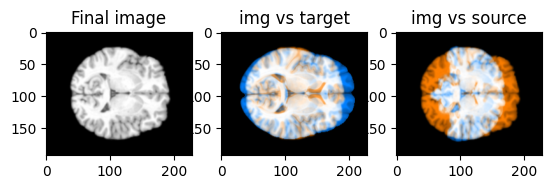

In [7]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    source_b.shape,
    image=False,
    rotation=True,
    translation=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),# - trans_s + trans_t,
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source_b.cpu(), momenta, save=True)

print(mr.mp.rot_mat)

# a3s.Visualize_GeodesicOptim_plt(mr, "random")
# rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
# rot_def += mr.mp.translation
rot_def = mr.mp.get_rotator_translator()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(rotated_source[..., ixi_img.shape[-1]//2].detach().cpu(), mr.target[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., ixi_img.shape[-1]//2].detach().cpu(), mr.source[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
plt.show()

## LDDMM

In [8]:

sigma= [3, 5, 7]
sigma = [(s,)*3 for s in sigma]
kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False)

datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    ixi_img.shape,
    image=True,
    rotation=True,
    translation=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)
rho = 1
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = rho,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=1e-6,
    n_iter=15,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)


mr.plot_cost()


True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>


OutOfMemoryError: CUDA out of memory. Tried to allocate 348.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 80.88 MiB is free. Process 117258 has 39.47 GiB memory in use. Of the allocated memory 36.38 GiB is allocated by PyTorch, and 2.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# fig, ax = plt.subplots(1,3)
T, _, D, H, W = ixi_img.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(mr.mp.residuals[0,0,..., slice_index].cpu(), cmap='gray')
ax[0].set_title(f'residuals')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')

ax[2].imshow(mr.mp.target[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'target')
plt.show()

In [ ]:
a3s.Visualize_GeodesicOptim_plt(mr, f"{name}_metaRigid_rho{rho}")


In [ ]:
mr.save(f"{name}_rigid_metamorphosis_colab",save_path="/content/drive/MyDrive/demeter_data/demeter_optim/")
